<a href="https://colab.research.google.com/github/mcgovey/compvision-playing-card-detection/blob/master/creating_playing_cards_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a data set of playing cards for object detection 
Author: Kevin McGovern

Last Updated: June 7, 2020

This notebook uses videos recorded of individual playing cards at different angles and under different lighting conditions to create a dataset of random scenes of cards. The images of cards are cropped from the videos and overlaid on random backgrounds with other cards to be used for training in the subsequent notebooks.

The data set creation of this project relies on the references listed at the bottom of the notebook.

# Download the video of the playing cards and unzip
You can download the videos I used to create this project if you'd like. However, you may want to record your own videos. Additionally, if you want this to generalize well to your deck of cards, you will likely have to record additional video clips.

In [0]:
!mkdir -p data; curl -L https://www.dropbox.com/s/or16zpsauj6751n/playing_card_video_files.zip?dl=0 > data/video.zip; unzip data/video.zip -d data; rm data/video.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    853      0 --:--:--  0:00:01 --:--:--   853
100  685M  100  685M    0     0  49.2M      0  0:00:13  0:00:13 --:--:-- 56.1M
Archive:  data/video.zip
   creating: data/playing_card_video_files/
  inflating: data/playing_card_video_files/10c.MOV  
  inflating: data/playing_card_video_files/10d.MOV  
  inflating: data/playing_card_video_files/10h.MOV  
  inflating: data/playing_card_video_files/10s.MOV  
  inflating: data/playing_card_video_files/2c.MOV  
  inflating: data/playing_card_video_files/2d.MOV  
  inflating: data/playing_card_video_files/2h.MOV  
  inflating: data/playing_card_video_files/2s.MOV  
  inflating: data/playing_card_video_

## Create variables used in the measurement of cards
If using a new set of cards, measure the dimensions from the image below (image attributed to [geaxgx](https://github.com/geaxgx/playing-card-detection)). Use a ruler and input your measurements in mm. You may have to tweak this a few times to get it right but you will know what needs to be altered once you create the bounding boxes below.

<img src="https://github.com/mcgovey/compvision-playing-card-detection/raw/master/ref/images/measurements.png" alt="Measurements" />

In [0]:
cardW=62
cardH=88
cornerXmin=2
cornerXmax=10
cornerYmin=3
cornerYmax=23

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

## Create video of each card

For each class in your data set, create a video of the card. Use various lighting conditions to create scenarios that will help your later model generalize to different scenarios better. 

Alternatively, you could take a picture of your card and alter the image to simulate lighting and blur conditions. The videos downloaded above only vary the lighting slightly.

## Load Imports

In [0]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False

import numpy as np
import cv2
if IS_COLAB_ENV:
  from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

import ntpath
import json

## Create functions display images and create a random file name

In [0]:

def display_img(img,polygons=[],channels="bgr",size=9):
    """Display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
      Attributes:
        img (pickle img): pickled image file to be displayed
        polygons (list): bounding box around image for display of target object
        channels (str): channels to be displayed
        size (int): size of image to be shown
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """Generate a random filename that has not already been used to saved/store images.

    Attributes:
      dirname (str): the directory name to save the files into
      suffixes (list): a list of suffixes to save the file as
      prefix (str): prefixes to be used for the file names to be saved

    Returns:
      fnames (str): filename to be used (dirname/prefixrandom.suffix) 
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

# Define variables to be used throughout

In [0]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"


# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])


# Get Describable Textures Dataset (DTD)

This dataset is used to get random backgrounds that we will use to generate differences in how each image is displayed.

If running locally, you will only need to run this once. Future runs can use the pickle file generated from the next four code blocks.

### Download DTD

In [0]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz --no-check-certificate

--2020-06-05 13:54:37--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  29.3MB/s    in 21s     

2020-06-05 13:54:58 (28.2 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



### Extract the DTD

In [0]:
!tar xf dtd-r1.0.1.tar.gz

### Load all *jpg from dtd subdirectories and save them in a pickle file

In [0]:
dtd_dir="dtd/images/"
bg_images=[]
for subdir in glob(dtd_dir+"/*"):
    for f in glob(subdir+"/*.jpg"):
        bg_images.append(mpimg.imread(f))
print("Nb of images loaded :",len(bg_images))
print("Saved in :",backgrounds_pck_fn)
pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

Nb of images loaded : 5640
Saved in : data/backgrounds.pck


In [0]:
# Clean-up
!rm -r dtd
!rm dtd-r1.0.1.tar.gz

### Load the pickle file generated from DTD for backgrounds
'backgrounds' is an instance of the class Backgrounds
To get a random background image, call the method : backgrounds.get_random

In [0]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()


Nb of images loaded : 5640


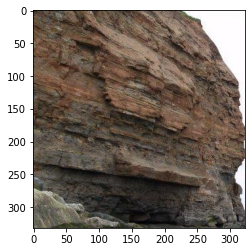

In [0]:
# Test: display a random background
_=backgrounds.get_random(display=True)

# Extract card images from video

The card videos contain information other than the cards. The functions below will be used to isolate the card images.

## Define the alphamask
The alphamask has 2 purposes:
- clean the border of the detected cards,
- make that border transparent. Cards are not perfect rectangles because corners are rounded. We need to make transparent the zone between the real card and its bounding rectangle, otherwise this zone will be visible in the final generated images of the dataset


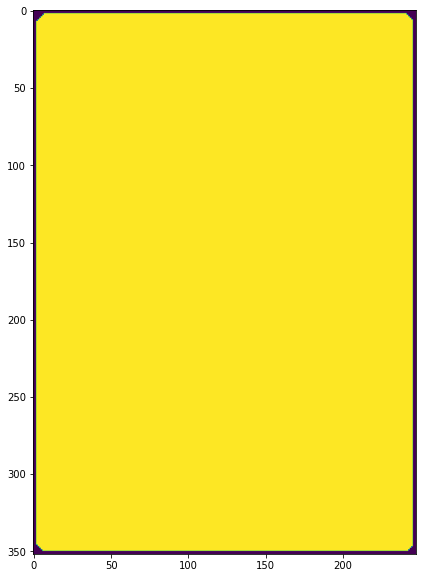

In [0]:
bord_size=2 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

## Create a function to Extract the card
The functions below create functions that are used in the computation of the various card images from the scenes generated.

In [0]:
def varianceOfLaplacian(img):
    """Compute the Laplacian of the image and then return the focus measure, which is simply the variance of the Laplacian
    
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    Attributes:
      img (pickled image): pickled image
    Returns:
      focus: a computed detection of the blur in the image
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def extract_card (img, output_fn=None, min_focus=100, debug=False):
    """Get the card from the image provided
    
    Attributes:
      img (pickled image): pickled image
      output_fn (function): used to add function to image before output
      min_focus (int): specified threshold for the amount of focus acceptable for an image to be used
      debug (bool): flag used when debugging function
    Returns:
      valid (bool): flag specifying if the image was valid
      imgwarp (picked image): the isolated card image created
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    
    # Find the contours in the edged image
    cnts,_ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    if debug:
      
        if IS_COLAB_ENV:
          cv2_imshow(gray)
          cv2_imshow(edge)
        else:
          cv2.imshow("Gray",gray)
          cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        if IS_COLAB_ENV:
          cv2_imshow(edge_bgr)
        else:
          cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
          if IS_COLAB_ENV:
            cv2_imshow(alphachannel)
            cv2_imshow(imgwarp)
          else:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid,imgwarp

## Function extract_cards_from_video

In [0]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=5, min_focus=10, debug=False):
    """Using the video path specified, extract the card images
    
    Attributes:
      video_fn (str): string specifying the location of the video
      output_dir (str): location for the file to be saved
      keep_ratio (int): some frame will be similar so keep specific ones
      min_focus (int): threshold for minimum focus to be kept
      debug (bool): flag used when debugging function
    Returns:
      imgs_list (list): list of the images extracted
    """
    if not os.path.isfile(video_fn):
        print(f"Video file {video_fn} does not exist !!!")
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list

In [0]:
# Test card extraction from a video   
# flip debug flag to true if you want to see the individual channels detected by this function
imgs=extract_cards_from_video("data/playing_card_video_files/Ah.MOV",output_dir="test/Ah",debug=False)
print("Nb images extracted:",len(imgs))

Nb images extracted: 53


# Card extraction from all the videos
We suppose we have for each card_name (ex: 2d, Kc, Ah) one video file named 'card_name.extension' (ex: 2d.avi, Kc.avi, Ah.avi) in a common directory (ex: data/video). If you use images instead of movies, the script below should work by setting the variable 'extension' below to "jpg" or "png". 
The cards from a video, or the card from an image, will be extracted in a subdirectory named 'card_name' placed in the directory 'imgs_dir' (ex: data/cards)


In [0]:
video_dir="data/playing_card_video_files"
extension="MOV"c
imgs_dir="data/cards"

for suit in card_suits:
    for value in card_values:
        
        card_name=value+suit
        video_fn=os.path.join(video_dir,card_name+"."+extension)
        output_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        imgs=extract_cards_from_video(video_fn,output_dir)
        print("Extracted images for %s : %d"%(card_name,len(imgs)))

Extracted images for As : 90
Extracted images for Ks : 56
Extracted images for Qs : 56
Extracted images for Js : 56
Extracted images for 10s : 42
Extracted images for 9s : 70
Extracted images for 8s : 59
Extracted images for 7s : 64
Extracted images for 6s : 51
Extracted images for 5s : 64
Extracted images for 4s : 48
Extracted images for 3s : 50
Extracted images for 2s : 70
Extracted images for Ah : 53
Extracted images for Kh : 43
Extracted images for Qh : 54
Extracted images for Jh : 66
Extracted images for 10h : 57
Extracted images for 9h : 45
Extracted images for 8h : 51
Extracted images for 7h : 64
Extracted images for 6h : 56
Extracted images for 5h : 67
Extracted images for 4h : 66
Extracted images for 3h : 80
Extracted images for 2h : 68
Extracted images for Ad : 84
Extracted images for Kd : 57
Extracted images for Qd : 78
Extracted images for Jd : 63
Extracted images for 10d : 50
Extracted images for 9d : 53
Extracted images for 8d : 61
Extracted images for 7d : 72
Extracted i

## Test output from above
Using the display_img function create show the output from the files. If your bounding boxes do not cover the full image, then this is where you may want to make alterations.


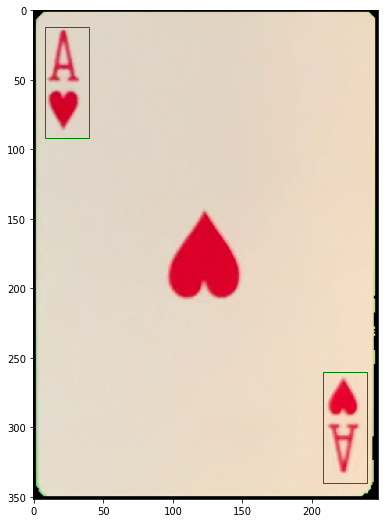

In [0]:
# Run for a single card
imgs_dir="data/cards"
imgs_fns=glob(imgs_dir+"/Ah/*.png")
img_fn=random.choice(imgs_fns)

display_img(cv2.imread(img_fn,cv2.IMREAD_UNCHANGED),polygons=[refCornerHL,refCornerLR])

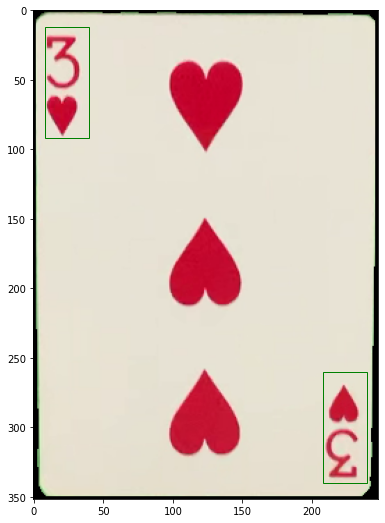

In [0]:
# Run a few times...
imgs_dir="data/cards"
imgs_fns=glob(imgs_dir+"/*/*.png")
img_fn=random.choice(imgs_fns)
display_img(cv2.imread(img_fn,cv2.IMREAD_UNCHANGED),polygons=[refCornerHL,refCornerLR])

# Finding the convex hulls
This section will help us check that within the bounding box we can accurately identify the convex hulls that surround the card number and suit. This is used validate that the cards can be used to output for later usage.

In [0]:
def findHull(img, corner=refCornerHL, debug="no"):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    """Using the video path specified, extract the card images
    
    Attributes:
      img (picked image): image in question
      corner (list): bounding box to be used to look inside the image for the information needed
      debug (bool): flag used when debugging function
    Returns:
      imgs_list (list): list of the images extracted
    """
    
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    thld=cv2.Canny(gray,30,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug!="no": cv2.imshow("thld",thld)
    
    # Find the contours
    contours,_=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=30 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.3 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug != "no" :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug != "no" and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            if IS_COLAB_ENV:
              cv2_imshow(strange_cnt)
            else:
              cv2.imshow("Strange contours",strange_cnt)
            
     
    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols   
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area=940 # TWEAK, deck and 'zoom' dependant
        max_hull_area=1000000 # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    
    if debug != "no" :
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        if IS_COLAB_ENV:
          cv2_imshow(zone)
          cv2_imshow(img)
        else:
          cv2.imshow("Zone",zone)
          cv2.imshow("Image",img)
        if ok and debug!="pause_always":
            key=cv2.waitKey(1)
        else:
            key=cv2.waitKey(0)
        if key==27:
            return None
    if ok == False:
        
        return None
    
    return hull_in_img

data/cards/9c/020813456.png


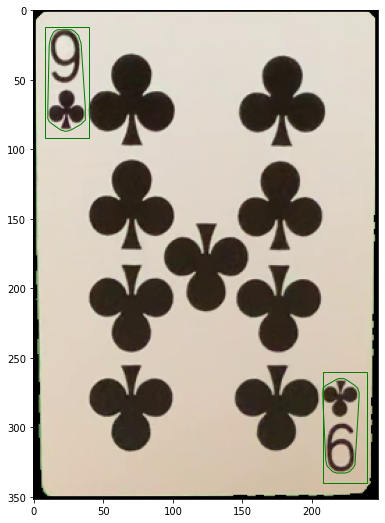

In [0]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug="no" 
imgs_dir="data/cards"
imgs_fns=glob(imgs_dir+"/*/*.png")
img_fn=random.choice(imgs_fns)
print(img_fn)
img=cv2.imread(img_fn,cv2.IMREAD_UNCHANGED)

hullHL=findHull(img,refCornerHL,debug=debug)
hullLR=findHull(img,refCornerLR,debug=debug)
display_img(img,[refCornerHL,refCornerLR,hullHL,hullLR])

if debug!="no": cv2.destroyAllWindows()

## Using the card images created above, calculate the convex hulls, and output to pickle
This will only need to be run once if you save the pickle file locally. The card images dataset generated will be loaded from pickle in the future.

In [0]:
imgs_dir="data/cards"

cards={}
for suit in card_suits:
    for value in card_values:
        card_name=value+suit        
        card_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(card_dir):
            print(f"!!! {card_dir} does not exist !!!")
            continue
        cards[card_name]=[]
        for f in glob(card_dir+"/*.png"):
            img=cv2.imread(f,cv2.IMREAD_UNCHANGED)
            hullHL=findHull(img,refCornerHL,debug="no") 
            if hullHL is None: 
                print(f"File {f} not used.")
                continue
            hullLR=findHull(img,refCornerLR,debug="no") 
            if hullLR is None: 
                print(f"File {f} not used.")
                continue
            # We store the image in "rgb" format (we don't need opencv anymore)
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
            cards[card_name].append((img,hullHL,hullLR))
        print(f"Nb images for {card_name} : {len(cards[card_name])}")



print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

cv2.destroyAllWindows()

Nb images for As : 90
Nb images for Ks : 56
Nb images for Qs : 56
File data/cards/Js/540197540.png not used.
File data/cards/Js/540851145.png not used.
Nb images for Js : 54
File data/cards/10s/912567477.png not used.
File data/cards/10s/105522335.png not used.
File data/cards/10s/157000335.png not used.
File data/cards/10s/723515662.png not used.
File data/cards/10s/879973855.png not used.
File data/cards/10s/429628489.png not used.
File data/cards/10s/098863087.png not used.
Nb images for 10s : 35
Nb images for 9s : 70
Nb images for 8s : 59
File data/cards/7s/767284096.png not used.
Nb images for 7s : 63
Nb images for 6s : 51
Nb images for 5s : 64
Nb images for 4s : 48
Nb images for 3s : 50
Nb images for 2s : 70
Nb images for Ah : 53
Nb images for Kh : 43
File data/cards/Qh/326984464.png not used.
File data/cards/Qh/770814636.png not used.
Nb images for Qh : 52
Nb images for Jh : 66
Nb images for 10h : 57
Nb images for 9h : 45
Nb images for 8h : 51
File data/cards/7h/714698221.png no

## Create a 'Cards' class that reads from the pickle file


In [0]:
class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2
    
cards = Cards()


Nb of cards loaded per name : {'As': 90, 'Ks': 56, 'Qs': 56, 'Js': 54, '10s': 35, '9s': 70, '8s': 59, '7s': 63, '6s': 51, '5s': 64, '4s': 48, '3s': 50, '2s': 70, 'Ah': 53, 'Kh': 43, 'Qh': 52, 'Jh': 66, '10h': 57, '9h': 45, '8h': 51, '7h': 63, '6h': 56, '5h': 67, '4h': 60, '3h': 80, '2h': 68, 'Ad': 84, 'Kd': 57, 'Qd': 77, 'Jd': 61, '10d': 46, '9d': 53, '8d': 61, '7d': 72, '6d': 56, '5d': 52, '4d': 45, '3d': 66, '2d': 83, 'Ac': 71, 'Kc': 56, 'Qc': 55, 'Jc': 53, '10c': 46, '9c': 59, '8c': 70, '7c': 64, '6c': 58, '5c': 58, '4c': 59, '3c': 55, '2c': 67}


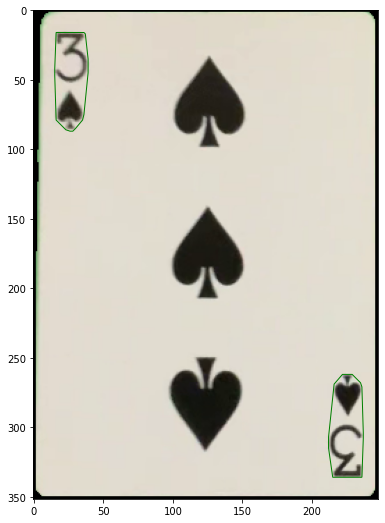

In [0]:
# Test: display a random card
_=cards.get_random(display=True)

# Create a scene
Using the image of the card overlaid on top of a background, create a scene to be used for the model. We will create different types of scenes (some with 1 card, some with 2 cards, and some with 3 cards). We will want to make sure the cards are layed on top of the background randomly without obscuring another cards bounding box.

### To save bounding boxes annotations in XML

In [0]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    """Create xml file using PASCAL VOC format. This is useful for capturing bounding box format of different labels.
    
    Attributes:
      xml_file (str): file name
      img_file (str): file name for the image that will be referenced
      listbba (list): bounding box specified for the file
      display (bool): flag for whether the xml file should be printed
    Returns:
      None
    """
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
        


In [0]:

# Scenario with 2 cards:
# The original image of a card has the shape (cardH,cardW,4)
# We first paste it in a zero image of shape (imgH,imgW,4) at position decalX, decalY
# so that the original image is centerd in the zero image
decalX=int((imgW-cardW)/2)
decalY=int((imgH-cardH)/2)

# Scenario with 3 cards : decal values are different
decalX3=int(imgW/2)
decalY3=int(imgH/2-cardH)

def kps_to_polygon(kps):
    """Helper to convert imgaug keypoints to shapely polygon 
    
    Attributes:
      kps (list): list of keypoints
    Returns:
      Polygon(pts) (shapely polygon): converted shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

def hull_to_kps(hull, decalX=decalX, decalY=decalY):
    """Helper to convert hull to imgaug keypoints
    
    Attributes:
      hull (list): hull of label within image
      decalX (int): specification of x hull coord
      decalY (int): specification of y hull coord
    Returns:
      kps (list): list of keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

def kps_to_BB(kps):
    """Helper to determine imgaug bounding box from imgaug keypoints
    
    Attributes:
      kps (list): list of keypoints
    Returns:
      imgaug (imgaug.BoundingBox): bounding box from image
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)


# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),
])

# For the 3 cards scenario, we use 3 imgaug transforms, the first 2 are for individual cards, 
# and the third one for the group of 3 cards
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))
])
trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))
])
transform_3cards = iaa.Sequential([
    iaa.Affine(translate_px={"x":decalX-decalX3,"y":decalY-decalY3}),
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)})   
])

# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})

def augment(img, list_kps, seq, restart=True):
    """Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
    
    Attributes:
      img (pickled image): picked image
      list_kps (list): list of keypoints
      seq (list): sequence of labels
      restart (bool): flag if the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    Returns:
      img_aug (picked image): pickled image that has been augmented
      list_kps_aug (list): list of augmented bounding box
      list_bbs (list): list of bounding box
    """
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug,list_kps_aug,list_bbs

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

class Scene:
    def __init__(self,bg,img1, class1, hulla1,hullb1,img2=None, class2=None,hulla2=None,hullb2=None,img3=None, class3=None,hulla3=None,hullb3=None):
        if img3 is not None:
            self.create3CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3)
        elif img2 is not None:
            self.create2CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2)
        else:
            self.create1CardsScense(bg,img1, class1, hulla1,hullb1)

    def create1CardsScense(self,bg,img1, class1, hulla1,hullb1):
        """Create a scene with one card
        
        Attributes:
          bg (pickled image): picked background image
          img1 (pickled image): picked image of playing card
          class1 (str): class for the image
          hulla1 (str): hull of image
          hullb1 (str): hull of image
        """
        kpsa1=hull_to_kps(hulla1)
        kpsb1=hull_to_kps(hullb1)
        # Randomly transform 1st card
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1
        self.img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],transform_1card)
        
        self.class1=class1
        
        self.listbba=[]
        for bb in self.bbs1:
            self.listbba.append(BBA(bb,class1))
            
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        
        
        
    def create2CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2):
        """Create a scene with two cards
        
        Attributes:
          bg (pickled image): picked background image
          img1 (pickled image): picked image of playing card
          class1 (str): class for the image
          hulla1 (str): hull of image
          hullb1 (str): hull of image
          img2 (pickled image): picked image of playing card
          class2 (str): class for the image
          hulla2 (str): hull of image
          hullb2 (str): hull of image
        """
        kpsa1=hull_to_kps(hulla1)
        kpsb1=hull_to_kps(hullb1)
        kpsa2=hull_to_kps(hulla2)
        kpsb2=hull_to_kps(hullb2)
        
        # Randomly transform 1st card
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1
        self.img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],transform_1card)

        # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        while True:
            self.listbba=[]
            self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
            self.img2[decalY:decalY+cardH,decalX:decalX+cardW,:]=img2
            self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],transform_1card)

            # mainPoly2: shapely polygon of card 2
            mainPoly2=kps_to_polygon(self.lkps2[0].keypoints[0:4])
            invalid=False
            intersect_ratio=0.1
            for i in range(1,3):
                # smallPoly1: shapely polygon of one of the hull of card 1
                smallPoly1=kps_to_polygon(self.lkps1[i].keypoints[:])
                a=smallPoly1.area
                # We calculate area of the intersection of card 1 corner with card 2
                intersect=mainPoly2.intersection(smallPoly1)
                ai=intersect.area
                # If intersection area is small enough, we accept card 2
                if (a-ai)/a > 1-intersect_ratio:
                    self.listbba.append(BBA(self.bbs1[i-1],class1))
                # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                elif (a-ai)/a>intersect_ratio:
                    invalid=True
                    break
                    
            if not invalid: break
            
        self.class1=class1
        self.class2=class2
        for bb in self.bbs2:
            self.listbba.append(BBA(bb,class2))
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        
        
        
    def create3CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3):
        """Create a scene with three cards
        
        Attributes:
          bg (pickled image): picked background image
          img1 (pickled image): picked image of playing card
          class1 (str): class for the image
          hulla1 (str): hull of image
          hullb1 (str): hull of image
          img2 (pickled image): picked image of playing card
          class2 (str): class for the image
          hulla2 (str): hull of image
          hullb2 (str): hull of image
          img3 (pickled image): picked image of playing card
          class3 (str): class for the image
          hulla3 (str): hull of image
          hullb3 (str): hull of image
        """
        
        kpsa1=hull_to_kps(hulla1,decalX3,decalY3)
        kpsb1=hull_to_kps(hullb1,decalX3,decalY3)
        kpsa2=hull_to_kps(hulla2,decalX3,decalY3)
        kpsb2=hull_to_kps(hullb2,decalX3,decalY3)
        kpsa3=hull_to_kps(hulla3,decalX3,decalY3)
        kpsb3=hull_to_kps(hullb3,decalX3,decalY3)
        self.img3=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img3[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img3
        self.img3,self.lkps3,self.bbs3=augment(self.img3,[cardKP,kpsa3,kpsb3],trans_rot1)
        self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img2[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img2
        self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],trans_rot2)
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img1

        while True:
            det_transform_3cards = transform_3cards.to_deterministic()
            _img3,_lkps3,self.bbs3=augment(self.img3,self.lkps3,det_transform_3cards, False)
            if _img3 is None: continue
            _img2,_lkps2,self.bbs2=augment(self.img2,self.lkps2,det_transform_3cards, False)
            if _img2 is None: continue
            _img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],det_transform_3cards, False)
            if _img1 is None: continue
            break
        self.img3=_img3
        self.lkps3=_lkps3
        self.img2=_img2
        self.lkps2=_lkps2
        self.img1=_img1
        
        self.class1=class1
        self.class2=class2
        self.class3=class3
        self.listbba=[BBA(self.bbs1[0],class1),BBA(self.bbs2[0],class2),BBA(self.bbs3[0],class3),BBA(self.bbs3[1],class3)]
        
        # Construct final image of the scene by superimposing: bg, img1, img2 and img3
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        mask3=self.img3[:,:,3]
        self.mask3=np.stack([mask3]*3,-1)
        self.final=np.where(self.mask3,self.img3[:,:,0:3],self.final)

    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
    def res(self):
        return self.final
    def write_files(self,save_dir,display=False, annot_type ='json'):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        
        # save the image
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        
        if annot_type == 'voc':
            create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)
        elif annot_type == 'both':
            create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)
            create_json_annotation(jpg_fn, self.listbba,display=display)
        else:
            create_json_annotation(jpg_fn, self.listbba,display=display)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.


In [0]:
def create_json_annotation(img_file,listbba,display=False):
    """Function to create json annotations
    
    Attributes:
      img_file (str): name of the image
      listbba (list): list of bounding box around the class
      display (bool): output the dictionary created
    """
    img_dict = {
        "image": ntpath.basename(img_file),
        "annotations": []
    }
    for bba in listbba:
        if display: print(bba.__dict__)
        img_dict['annotations'].append({
            "label":bba.classname,
            "coordinates":{
                "x":bba.x1,
                "y":bba.y1,
                "width":bba.x2-bba.x1,
                "height":bba.y2-bba.y1
            }
        })
    if display: print(img_dict)
    with open(os.path.splitext(img_file)[0]+'.json', 'w') as f:
        json.dump(img_dict, f)

## Test the scene creation functions

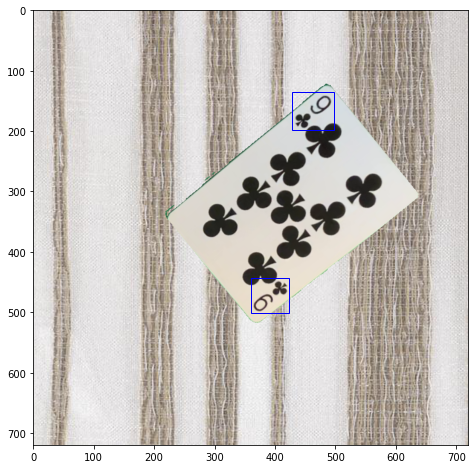

In [0]:
# Test generation of a scene with 2 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1)
newimg.display()

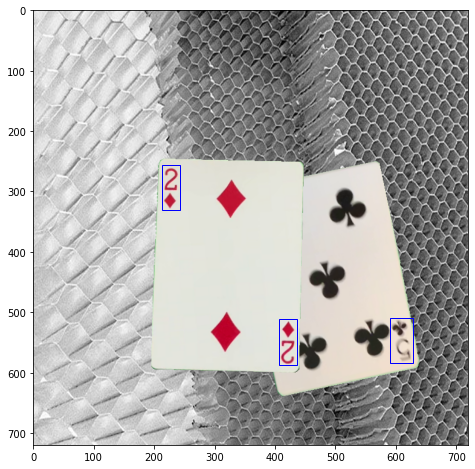

In [0]:
# Test generation of a scene with 2 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
newimg.display()

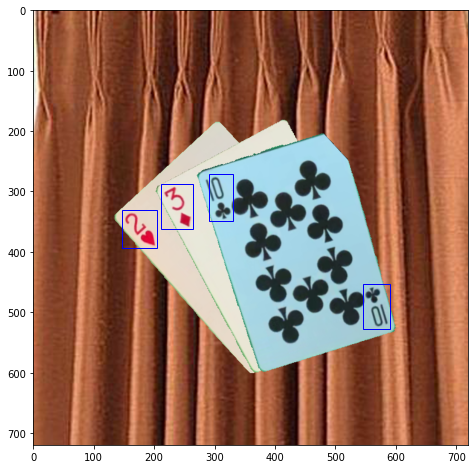

In [0]:
# Test generation of a scene with 3 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()
img3,card_val3,hulla3,hullb3=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()

# Generate the datasets
Generate the datasets from the scenes above. Change the number of cards to create larger or smaller datasets. For my model, I created 9000 scenes. The next models will create the train/test split for you so make sure you have enough files to effectively split your images.


## Generation of 1 card scenes

In [0]:
nb_cards_to_generate=200
save_dir="data/scenes/card_train"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1)
    
    output_dir=os.path.join(save_dir,card_val1)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    
    newimg.write_files(output_dir)
    

100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


## Generation of the 2 cards scenes

In [0]:
nb_cards_to_generate=400
save_dir="data/scenes/card_train"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    img2,card_val2,hulla2,hullb2=cards.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
    newimg.write_files(save_dir, annot_type='both')


100%|██████████| 400/400 [01:01<00:00,  6.51it/s]


## Generation of the 3 cards scenes

In [0]:
nb_cards_to_generate=400
save_dir="data/scenes/card_train"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cards.get_random()
    img2,card_val2,hulla2,hullb2=cards.get_random()
    img3,card_val3,hulla3,hullb3=cards.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
    newimg.write_files(save_dir, annot_type='both')


100%|██████████| 400/400 [01:58<00:00,  3.38it/s]


# Create JSON data
Create a master json file that specifies each file, the label, and the bounding box

In [0]:
def master_json_data(read_dir, save_dir, file_name):
    """Creates a master json file of all the images and their corresponding labels. Useful for Create ML models
    
    Attributes:
      read_dir (str): name of the directory to find the json files
      save_dir (str): name of the directory to save the master json file
      filename (str): output file name
    """
    
    json_data_all = []
    
    for pos_json in os.listdir(read_dir):
        if pos_json.endswith('.json'):
            with open(read_dir + "/" + pos_json) as json_file:
                json_data_all.append(json.load(json_file))



    with open(save_dir+file_name+'.json', 'w') as f:
        json.dump(json_data_all, f)

In [0]:
save_dir="data/scenes/"
read_dir="data/scenes/card_train"
file_name="card_train"
master_json_data(read_dir, save_dir, file_name)

In [0]:
# run to cleanup individual json files if no longer needed
json_items = os.listdir(read_dir)
for item in json_items:
    if item.endswith(".json"):
        os.remove(os.path.join(read_dir, item))

os.rename(save_dir + file_name + ".json", read_dir + '/' + file_name + ".json")

# Create csv upload file
Create a csv that will be used by Turi Create

In [0]:
import pandas as pd

read_dir="data/scenes/card_train/"
file_name="card_train"
with open(read_dir + file_name + ".json") as json_file:
    json_train = json.load(json_file)

In [0]:
# create a df from json    
img_class = pd.DataFrame(
    [p['image'], anno['label'], anno['coordinates']['x'], anno['coordinates']['x']+anno['coordinates']['width'], anno['coordinates']['y'], anno['coordinates']['y']+anno['coordinates']['height']] for p in json_train for anno in p['annotations']
)

In [0]:
# clean the file column names and reorder
img_class.reset_index(inplace=True)
img_class.columns = ['id','image','name','xMin','xMax','yMin','yMax']
img_class = img_class.loc[:,['image','id','name','xMin','xMax','yMin','yMax']]
img_class

,image,id,name,xMin,xMax,yMin,yMax
0,044543937.jpg,0,Kd,295,348,330,376
1,044543937.jpg,1,Js,273,306,343,394
2,044543937.jpg,2,Ac,228,256,357,407
3,044543937.jpg,3,Ac,64,90,246,295
4,706008498.jpg,4,7h,553,600,498,577
...,...,...,...,...,...,...,...
3012,357212858.jpg,3012,As,508,556,284,317
3013,357212858.jpg,3013,As,304,353,321,356
3014,250307257.jpg,3014,Qd,624,669,483,557
3015,250307257.jpg,3015,9d,608,686,233,262


In [0]:
# save the file that is used by Turi Create
img_class.to_csv('data/scenes/card_train/img_class_train.csv',index=False, header=True)

# References

The below links were used to influence the direction of the data set creation.

- [Video of project used for inspiration](https://www.youtube.com/watch?v=pnntrewH0xg&feature=youtu.be)

- [Github of project used as basis for dataset creation](https://github.com/geaxgx/playing-card-detection)